# Part 1: Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


plt.style.use("seaborn")
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("../input/predict-closed-questions-on-stack-overflow/train-sample.csv")
df.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


In [3]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])

Total rows: 140272
Total columns: 15


The **PostId** and **OwnerUserId** columns are ID columns and do not have any predictive power so they can be dropped.

In [4]:
df.drop(columns=["PostId", "OwnerUserId"], inplace=True)

Analysing the number of unique values in various columns

In [5]:
df.nunique()

PostCreationDate                       140118
OwnerCreationDate                       94149
ReputationAtPostCreation                 6423
OwnerUndeletedAnswerCountAtPostTime       965
Title                                  140192
BodyMarkdown                           140270
Tag1                                     5209
Tag2                                     9292
Tag3                                    11080
Tag4                                    10027
Tag5                                     7605
PostClosedDate                          70070
OpenStatus                                  5
dtype: int64

Analysing the percentage of missing values in various columns:

In [6]:
df.isna().sum()*100/df.shape[0]

PostCreationDate                        0.000000
OwnerCreationDate                       0.000000
ReputationAtPostCreation                0.000000
OwnerUndeletedAnswerCountAtPostTime     0.000000
Title                                   0.000000
BodyMarkdown                            0.000000
Tag1                                    0.007129
Tag2                                   19.427256
Tag3                                   45.880860
Tag4                                   71.733489
Tag5                                   88.797479
PostClosedDate                         50.000000
OpenStatus                              0.000000
dtype: float64

There are so many missing values in the columns **Tag2** to **Tag5** and **PostClosedDate** but only a small fraction of data points (about 160) in the **Tag1** column is missing. This tells that each question has atleast one tag associated with it. Moreover, some questions do not have any **BodyMarkdown** thus the content of such questions must be contained in the **Title**.

In [7]:
df.loc[df["Tag1"].isna(), "Tag1"] = df["Tag1"].mode()

drop_cols = ["Tag2", "Tag3", "Tag4", "Tag5", "PostClosedDate"]
df.drop(drop_cols, axis=1, inplace=True)

Renaming some columns with very long names

In [8]:
name_map = {
    "PostCreationDate": "PostDate",
    "OwnerCreationDate": "OwnrDate",
    "ReputationAtPostCreation": "OwnrRep",
    "OwnerUndeletedAnswerCountAtPostTime": "AnsCount"
}

df.rename(columns=name_map, inplace=True)

# Part 2: Feature Engineering

We can extract several date and time features from the columns - **PostCreationDate** and **OwnerCreationDate** - and binary encoding them. Further, we can create a new feature signifying how old the owner account is by finding the difference between these two datetime columns in seconds.

In [9]:
import category_encoders as ce


def datetime_features(df):
    df["PostDate"] = pd.to_datetime(df["PostDate"])
    df["OwnrDate"] = pd.to_datetime(df["OwnrDate"])

    df["PostDay"] = df["PostDate"].dt.dayofweek
    df["PostMonth"] = df["PostDate"].dt.month
    df["PostYear"] = df["PostDate"].dt.year
    df["PostHour"] = df["PostDate"].dt.hour
    df["PostMin"] = df["PostDate"].dt.minute

    df["OwnrDay"] = df["OwnrDate"].dt.weekday
    df["OwnrMonth"] = df["OwnrDate"].dt.month
    df["OwnrYear"] = df["OwnrDate"].dt.year
    df["OwnrHour"] = df["OwnrDate"].dt.hour
    df["OwnrMin"] = df["OwnrDate"].dt.minute

    df["AccAge"] = (df["PostDate"] - df["OwnrDate"])/np.timedelta64(1, 's')

    del df["PostDate"]
    del df["OwnrDate"]

    cols = [
        "PostDay",
        "PostMonth",
        "PostYear",
        "PostHour",
        "PostMin",
        "OwnrDay",
        "OwnrMonth",
        "OwnrYear",
        "OwnrHour",
        "OwnrMin"
    ]

    encoder = ce.binary.BinaryEncoder(cols=cols)
    sub_cols = encoder.fit_transform(df[cols])

    df = pd.concat([df, sub_cols], axis=1)
    df.drop(cols, axis=1, inplace=True)

    return df


df = datetime_features(df)

Concatenating **Title** and **BodyMarkdown** to form a new column **QuestionText**.

In [10]:
df["BodyMarkdown"] = df["Title"] + df["BodyMarkdown"]
df.drop(columns=["Title"], axis=1, inplace=True)
df.rename(columns={"BodyMarkdown":"QuestionText"}, inplace=True)

Since, **Tag1** has many classes, one-hot encoding won't be a good idea. Performing binary encoding to encode all the categorical features. Also label encoding the target label since they are strings.

In [11]:
import category_encoders as ce


encoder = ce.binary.BinaryEncoder()
tag1_bits = encoder.fit_transform(df["Tag1"])

df = pd.concat([df, tag1_bits], axis=1)
df.drop(["Tag1"], axis=1, inplace=True)

target_map = {
    "not a real question": 0,
    "not constructive": 1,
    "off topic": 2,
    "open": 3,
    "too localized": 4
}

df["OpenStatus"] = df["OpenStatus"].map(target_map)

In [12]:
df.head()

,OwnrRep,AnsCount,QuestionText,OpenStatus,AccAge,PostDay_0,PostDay_1,PostDay_2,PostMonth_0,PostMonth_1,PostMonth_2,PostMonth_3,PostYear_0,PostYear_1,PostYear_2,PostHour_0,PostHour_1,PostHour_2,PostHour_3,PostHour_4,PostMin_0,PostMin_1,PostMin_2,PostMin_3,PostMin_4,PostMin_5,OwnrDay_0,OwnrDay_1,OwnrDay_2,OwnrMonth_0,OwnrMonth_1,OwnrMonth_2,OwnrMonth_3,OwnrYear_0,OwnrYear_1,OwnrYear_2,OwnrHour_0,OwnrHour_1,OwnrHour_2,OwnrHour_3,OwnrHour_4,OwnrMin_0,OwnrMin_1,OwnrMin_2,OwnrMin_3,OwnrMin_4,OwnrMin_5,Tag1_0,Tag1_1,Tag1_2,Tag1_3,Tag1_4,Tag1_5,Tag1_6,Tag1_7,Tag1_8,Tag1_9,Tag1_10,Tag1_11,Tag1_12
0,1,2,For Mongodb is it better to reference an objec...,3,21009539.0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,192,24,How to insert schemalocation in a xml document...,3,10547952.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,Too many lookup tables What are the adverse ef...,3,1414.0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1
3,4,1,What is this PHP code in VB.netI am looking fo...,4,22373759.0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,334,14,Spring-Data mongodb querying multiple classes ...,3,39151167.0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


# Part 3: Model building

Splitting the dataset into training and validation sets and then scaling with sklearn RobustScaler.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df["OpenStatus"])
del df

train_text = train_df[["QuestionText"]]
train_meta = train_df.drop(["OpenStatus", "QuestionText"], axis=1)
train_target = train_df["OpenStatus"]
del train_df

val_text = val_df[["QuestionText"]]
val_meta = val_df.drop(["OpenStatus", "QuestionText"], axis=1)
val_target = val_df["OpenStatus"]
del val_df

scaler = RobustScaler()
train_meta = scaler.fit_transform(train_meta)
val_meta = scaler.transform(val_meta)

Since the dateset contains both text and meta data, we will require a multi-input neural network to process different kinds of input data type. The text data will pass through stacked LSTMs and then join with meta data where they will further pass through dense layers.

In [14]:
from tensorflow.keras.layers import TextVectorization


text2vec = TextVectorization()
text2vec.adapt(train_text)

print("Total tokens in training data:", text2vec.vocabulary_size())
print("Largest length of any sequence:", text2vec(train_text).shape[1])

2022-02-28 22:04:04.195694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:04:04.319876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:04:04.321102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:04:04.322560: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Total tokens in training data: 725844


2022-02-28 22:04:23.347992: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4435713576 exceeds 10% of free system memory.


Largest length of any sequence: 4941


In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model


MAX_TOKENS = 10000
MAX_LEN = 150
EMBED_DIM = 50
NUM_CLASSES = train_target.nunique()

text2vec = TextVectorization(max_tokens=MAX_TOKENS, output_sequence_length=MAX_LEN, name="text2vec")
text2vec.adapt(train_text)

text_input = layers.Input(shape=(1,), dtype=tf.string, name="text_input")
x = text2vec(text_input)
x = layers.Embedding(input_dim=MAX_TOKENS, output_dim=EMBED_DIM, input_length=MAX_LEN, name="embedding")(x)
x = layers.LSTM(units=128, name="hidden_lstm")(x)

meta_input = layers.Input(shape=train_meta.shape[1:], name="meta_input")
y = layers.Concatenate()([x, meta_input])
y = layers.Dense(units=256, activation="selu", kernel_initializer="lecun_normal", name="hidden_dense_1")(y)
y = layers.BatchNormalization()(y)
y = layers.Dense(units=64, activation="selu", kernel_initializer="lecun_normal", name="hidden_dense_2")(y)
y = layers.Dense(units=NUM_CLASSES, activation="softmax", name="softmax_output")(y)

model = Model(inputs=[text_input, meta_input], outputs=y, name="NLP_Model")

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "NLP_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
text2vec (TextVectorization)    (None, 150)          0           text_input[0][0]                 
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 50)      500000      text2vec[0][0]                   
__________________________________________________________________________________________________
hidden_lstm (LSTM)              (None, 128)          91648       embedding[0][0]                  
__________________________________________________________________________________________

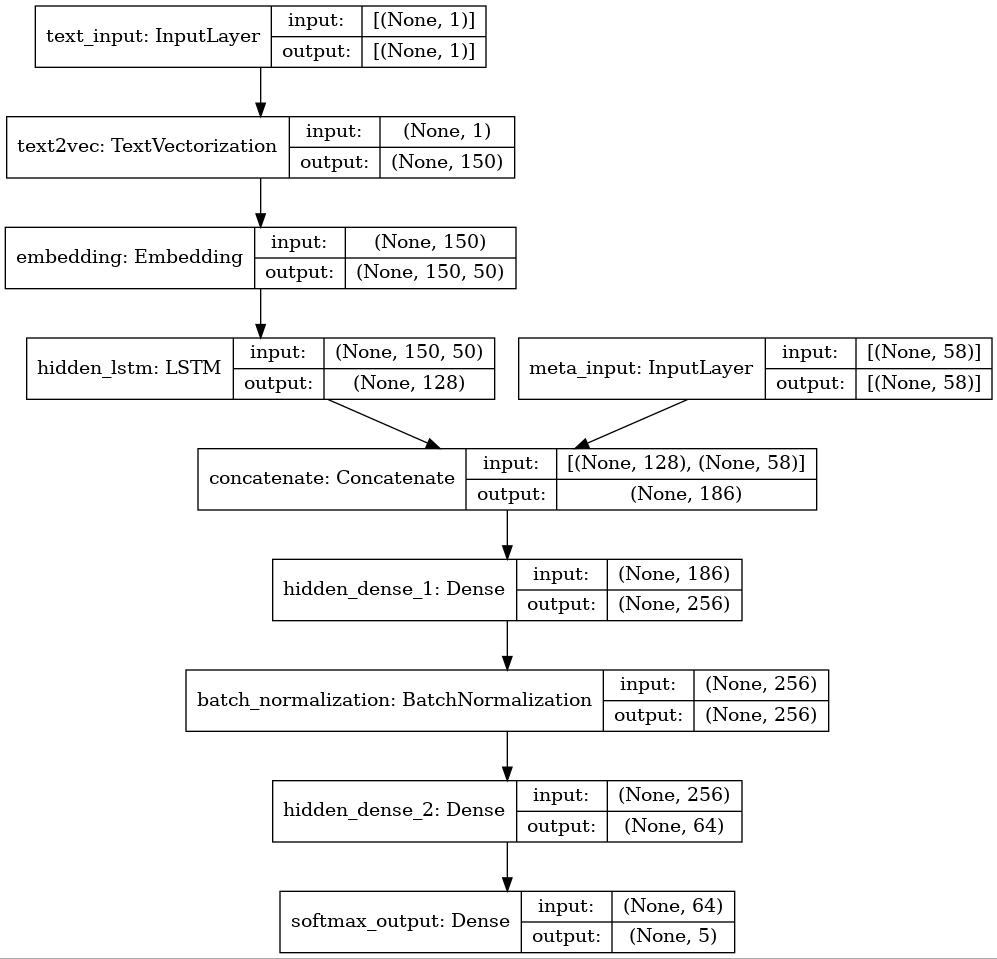

In [16]:
from tensorflow.keras.utils import plot_model


plot_model(
    model=model,
    to_file="model.jpeg",
    show_shapes=True
)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=True
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=True
)

callbacks = [reduce_lr, early_stop]

In [18]:
history = model.fit(
    x=[train_text, train_meta],
    y=train_target,
    batch_size=256,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=([val_text, val_meta], val_target),
    shuffle=True
)

Epoch 1/100


2022-02-28 22:04:42.554052: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


439/439 [==============================] - 18s 32ms/step - loss: 1.0932 - accuracy: 0.5778 - val_loss: 0.9983 - val_accuracy: 0.6203
Epoch 2/100
439/439 [==============================] - 14s 32ms/step - loss: 0.9707 - accuracy: 0.6291 - val_loss: 1.0745 - val_accuracy: 0.6071
Epoch 3/100
439/439 [==============================] - 13s 31ms/step - loss: 0.9378 - accuracy: 0.6449 - val_loss: 1.0032 - val_accuracy: 0.6128
Epoch 4/100
439/439 [==============================] - 13s 31ms/step - loss: 0.9061 - accuracy: 0.6613 - val_loss: 0.9909 - val_accuracy: 0.6196
Epoch 5/100
439/439 [==============================] - 14s 32ms/step - loss: 0.8882 - accuracy: 0.6699 - val_loss: 1.0305 - val_accuracy: 0.6169
Epoch 6/100
439/439 [==============================] - 14s 31ms/step - loss: 0.8668 - accuracy: 0.6800 - val_loss: 1.1798 - val_accuracy: 0.5833
Epoch 7/100
439/439 [==============================] - 14s 32ms/step - loss: 0.8393 - accuracy: 0.6939 - val_loss: 0.9947 - val_accuracy: 0.64

In [19]:
model.evaluate([val_text, val_meta], val_target)

877/877 [==============================] - 7s 8ms/step - loss: 0.9909 - accuracy: 0.6196


[0.9908987283706665, 0.6196399927139282]